In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import json

from rich import print
from python.analysis import Master, BeamParticleSelection, PFOSelection, Plots, shower_merging, vector, Tags

import awkward as ak
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from particle import Particle
from scipy.optimize import curve_fit


shower_merging.SetPlotStyle(extend_colors = True)

In [2]:
mc = Master.Data("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", nTuple_type = Master.Ntuple_Type.PDSP)
data = Master.Data("work/ROOTFiles/PDSPAnalyser/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01.root", nTuple_type = Master.Ntuple_Type.PDSP)

samples = {"mc" : mc, "data": data}

def FilterSamples(samples : dict, masks : dict, PFO : bool = False):
    for s in samples:
        if PFO:
            samples[s].Filter([masks[s]])
        else:
            samples[s].Filter([masks[s]], [masks[s]])

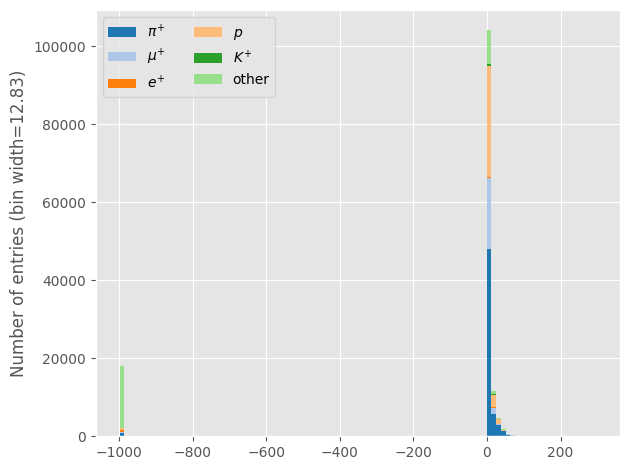

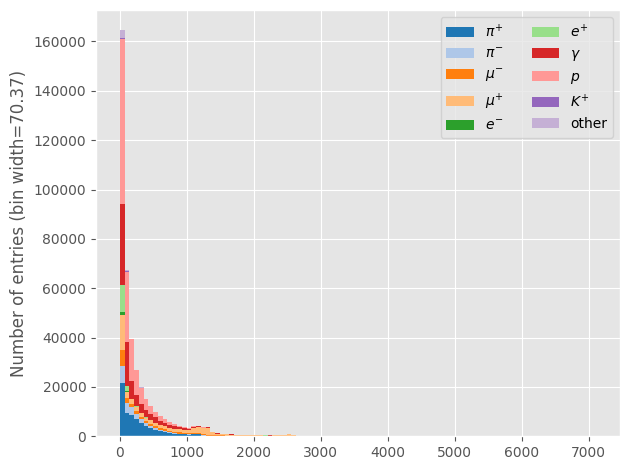

In [4]:
Plots.PlotTagged(mc.recoParticles.beam_nHits, Tags.GenerateTrueBeamParticleTags(mc))
Plots.PlotTagged(mc.recoParticles.nHits, Tags.GenerateTrueParticleTags(mc))

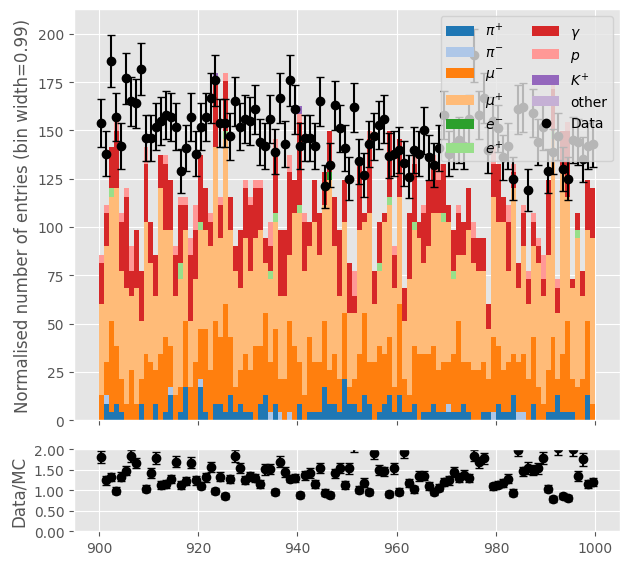

In [19]:
Plots.PlotTagged(mc.recoParticles.energy, Tags.GenerateTrueParticleTags(mc), data2 = ak.flatten(data.recoParticles.energy), y_scale = "linear", norm = True, x_range = [900, 1000])

# Beam Particle Selection

In [3]:
masks = {s : BeamParticleSelection.CaloSizeCut(samples[s]) for s in samples}
FilterSamples(samples, masks)

number of entries before|after CaloSizeCut: 141548|125589
number of entries before|after CaloSizeCut: 1349399|587932


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


number of entries before|after PiBeamSelection: 125589|91248
number of entries before|after PiBeamSelection: 587932|248398


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


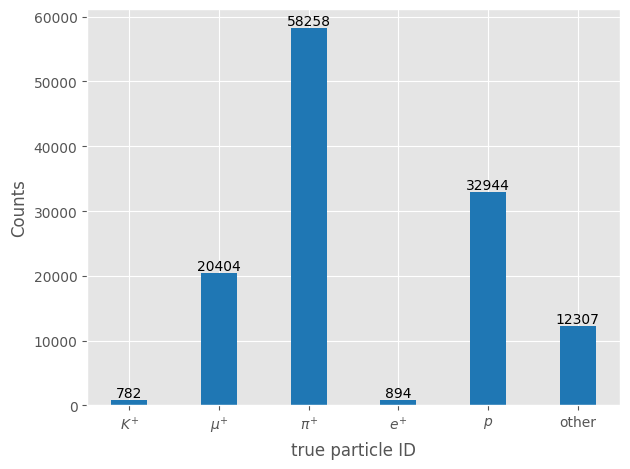

In [4]:
masks = {
    "mc" : BeamParticleSelection.PiBeamSelection(samples["mc"]),
    "data" : BeamParticleSelection.PiBeamSelection(samples["data"], use_beam_inst = True)
}

counts = Tags.GenerateTrueBeamParticleTags(samples["mc"])
for i in counts:
    counts[i] = ak.sum(counts[i].mask)

bar_data = []
for tag in counts:
    bar_data.extend([tag]*counts[tag])
Plots.PlotBar(bar_data, xlabel = "true particle ID")

FilterSamples(samples, masks)

number of entries before|after PandoraTagCut: 91248|87403
number of entries before|after PandoraTagCut: 248398|232423


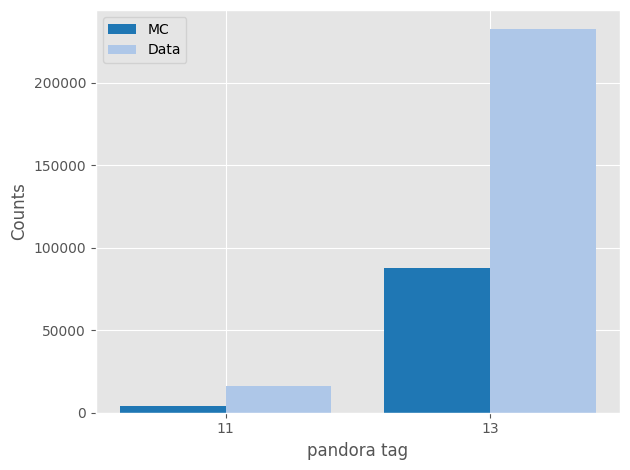

In [5]:
masks = {s : BeamParticleSelection.PandoraTagCut(samples[s]) for s in samples}

if data is None:
    Plots.PlotBar(samples["mc"])
else:
    Plots.PlotBarComparision(samples["mc"].recoParticles.beam_pandora_tag, samples["data"].recoParticles.beam_pandora_tag, label_1 = "MC", label_2 = "Data", xlabel = "pandora tag")

FilterSamples(samples, masks)

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


number of entries before|after MichelScoreCut: 87403|80620
number of entries before|after MichelScoreCut: 232423|224513


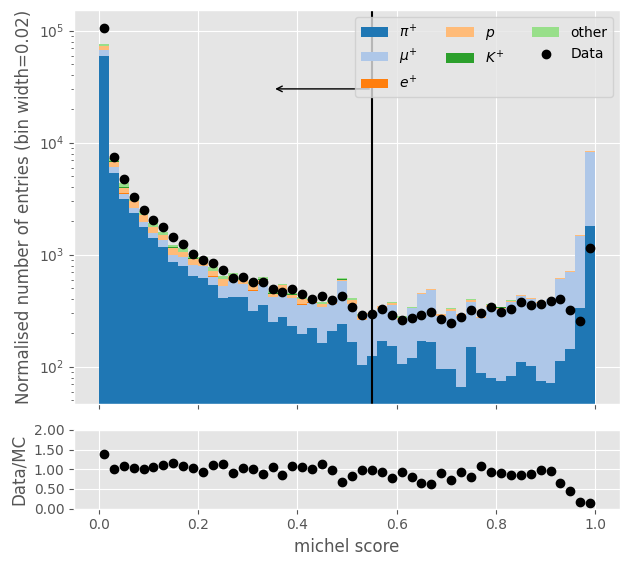

In [6]:
# michel score cut

scores = {}
for s in samples:
    score = ak.where(samples[s].recoParticles.beam_nHits != 0, samples[s].recoParticles.beam_michelScore / samples[s].recoParticles.beam_nHits, -999)
    masks[s] = BeamParticleSelection.MichelScoreCut(samples[s])
    scores[s] = score

Plots.PlotTagged(scores["mc"], Tags.GenerateTrueBeamParticleTags(samples["mc"]), data2 = np.array(scores["data"]), x_range = (0, 1), y_scale = "log", bins = 50, x_label = "michel score", ncols = 3, norm = True)
Plots.DrawCutPosition(0.55, face = "left")

# events.Filter([mask], [mask])
FilterSamples(samples, masks)


{'x': -30.708878970445017, 'y': 422.513339530776, 'z': -1.3107763965386725}

{'x': 5.108203334336736, 'y': 5.43951850510547, 'z': 2.1897075712407785}

{'x': -28.360391519803432, 'y': 424.66197904820547, 'z': 2.3194918611194035}

{'x': 5.0033233828757595, 'y': 7.389085741055516, 'z': 3.1438805727060304}

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1049: RuntimeWarning: invalid value encountered in divide
  ratio = h_data / h_mc # data / MC
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1049: RuntimeWarning: divide by zero encountered in divide
  ratio = h_data / h_mc # data / MC


dxy cut: (114104, 95558)

dxy cut: (91827, 74802)

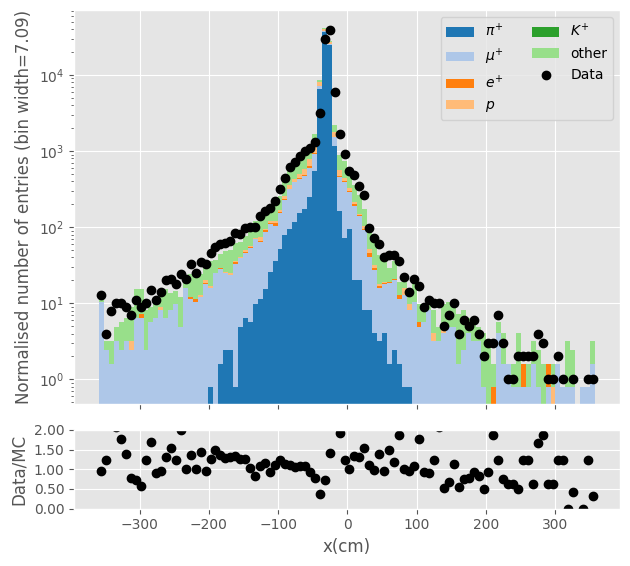

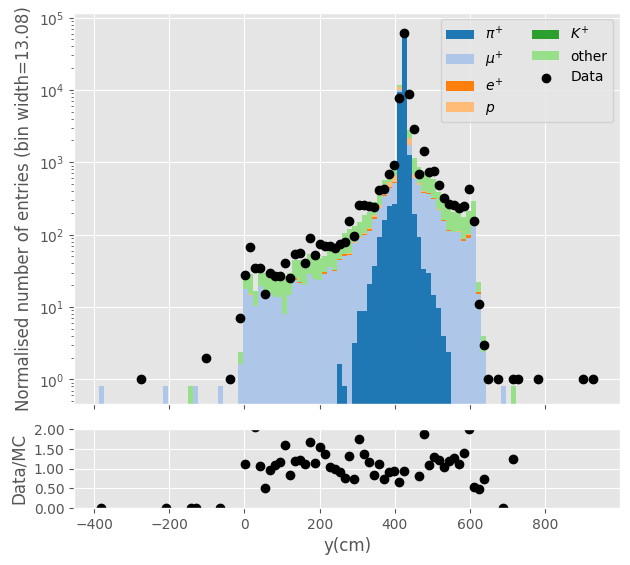

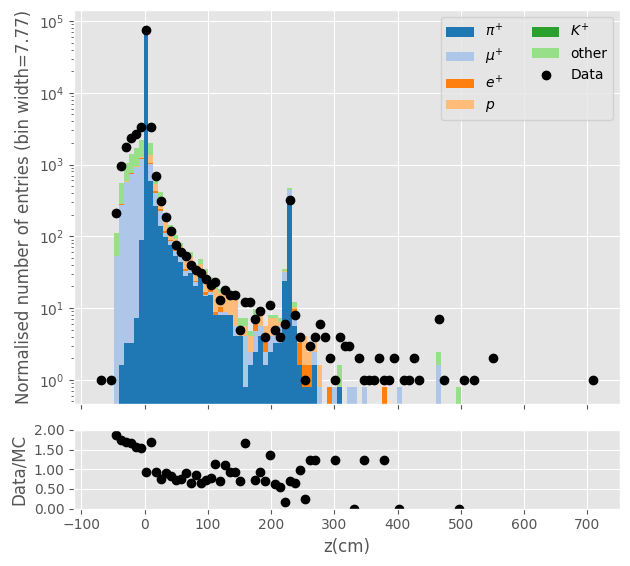

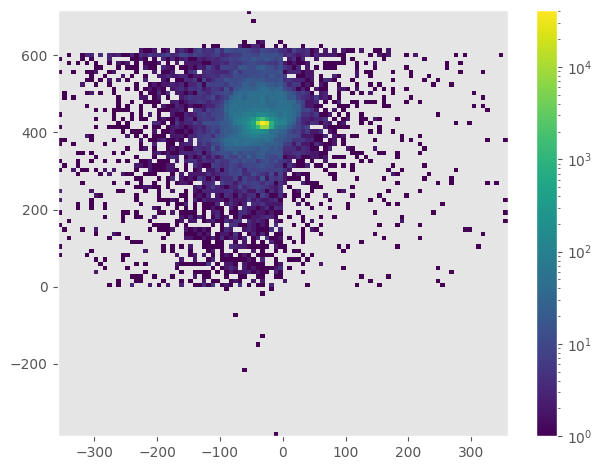

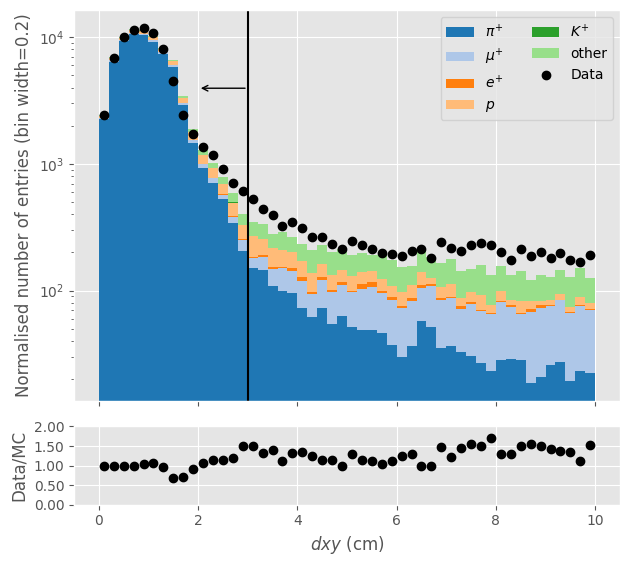

In [8]:
# Beam quality cuts

# Define the Gaussian function
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def fit_gaussian(data, bins, range = None):
    if range is None:
        range = [min(data), max(data)]
    y, bins_edges = np.histogram(np.array(data), bins = bins, range = range)
    bin_centers = (bins_edges[1:] + bins_edges[:-1]) / 2
    return curve_fit(gaussian, bin_centers, y, p0 = (0, ak.mean(data), ak.std(data)))

def fits(events):
    mu = {}
    sigma = {}
    for i in ["x", "y", "z"]:
        popt, _ = fit_gaussian(events.recoParticles.beam_startPos[i], bins = 100)
        mu[i] = popt[1]
        sigma[i] =popt[2]

    print(mu)
    print(sigma)
    return mu, sigma

def norm(x, mu, sigma):
    return (x - mu) / sigma

mu_mc, sigma_mc = fits(mc)
mu_data, sigma_data = fits(data)

mu = {"mc" : mu_mc, "data" : mu_data}
sigma = {"mc": sigma_mc, "data" : sigma_data}

for i in ["x", "y", "z"]:
    Plots.PlotTagged(mc.recoParticles.beam_startPos[i], Tags.GenerateTrueBeamParticleTags(mc), data2 = data.recoParticles.beam_startPos[i], x_label = i + "(cm)", y_scale = "log", norm = True)

Plots.PlotHist2D(mc.recoParticles.beam_startPos["x"], mc.recoParticles.beam_startPos["y"])

dxy = {s : (norm(samples[s].recoParticles.beam_startPos.x, mu[s]["x"], sigma[s]["x"])**2 + norm(samples[s].recoParticles.beam_startPos.y, mu[s]["y"], sigma[s]["y"])**2)**0.5 for s in samples}

Plots.PlotTagged(dxy["mc"], Tags.GenerateTrueBeamParticleTags(mc), data2 = np.array(dxy["data"]), bins = 50, x_label = "$dxy$ (cm)", y_scale = "log", x_range = [0, 10], norm = True)
Plots.DrawCutPosition(3, arrow_length = 1, face = "left")

masks = {s : dxy[s] < 3 for s in samples}

[print(f"dxy cut: {BeamParticleSelection.CountMask(masks[s])}") for s in masks]
FilterSamples(samples, masks)


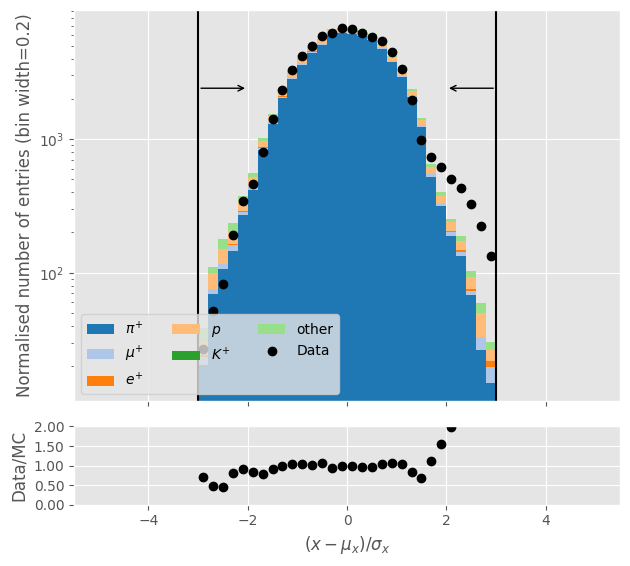

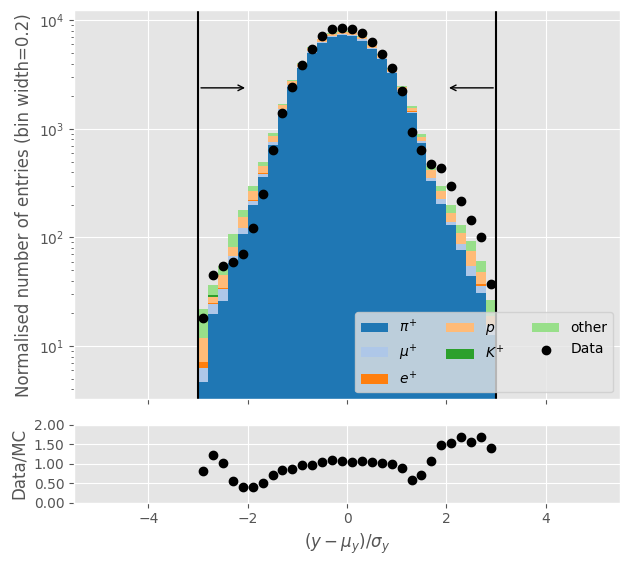

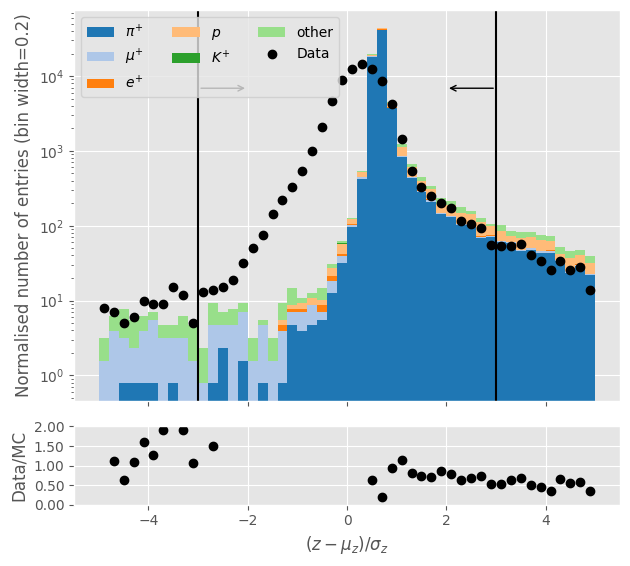

In [9]:
deltas_mc = {}
deltas_data = {}
for i in ["x", "y", "z"]:
    deltas_mc[i] = norm(samples["mc"].recoParticles.beam_startPos[i], mu["mc"][i], sigma["mc"][i])
    deltas_data[i] = norm(samples["data"].recoParticles.beam_startPos[i], mu["data"][i], sigma["data"][i])
    Plots.PlotTagged(deltas_mc[i], Tags.GenerateTrueBeamParticleTags(mc), data2 = np.array(deltas_data[i]), bins = 50, x_range = [-5, 5], y_scale = "log", x_label = f"$(" + i + "- \mu_{"+ i + "} )/ \sigma_{" + i + "}$", ncols = 3, norm = True)
    Plots.DrawCutPosition(-3, arrow_length = 1, face = "right")
    Plots.DrawCutPosition(3, arrow_length = 1, face = "left")


masks = {
    "mc" : (deltas_mc["z"] > -3) & (deltas_mc["z"] < 3),
    "data" : (deltas_data["z"] > -3) & (deltas_data["z"] < 3)
}

FilterSamples(samples, masks)

# events.Filter([mask], [mask])
# print(f"dz cut: {BeamParticleSelection.CountMask(mask)}")

{'x': -0.20369405717571065, 'y': -0.19439303449782533, 'z': 0.9588226431838246}

{'x': 0.03504542739241238, 'y': 0.040920734161341156, 'z': 0.015081713677196363}

{'x': -0.18764534953604065, 'y': -0.23954456449585534, 'z': 0.9521091764458168}

{'x': 0.04002031681534546, 'y': 0.05553126217255625, 'z': 0.016855218788914345}

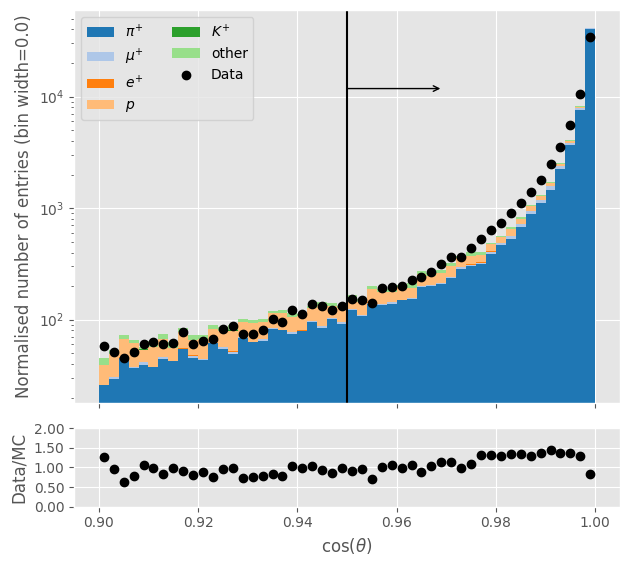

In [10]:
beam_dir = {s : vector.normalize(vector.sub(samples[s].recoParticles.beam_endPos, samples[s].recoParticles.beam_startPos)) for s in samples}

def fits_dir(dir):
    mu_dir = {}
    sigma_dir = {}
    for i in ["x", "y", "z"]:
        popt, _ = fit_gaussian(dir[i], bins = 50)
        mu_dir[i] = popt[1]
        sigma_dir[i] = popt[2]

    print(mu_dir)
    print(sigma_dir)
    return mu_dir, sigma_dir

mu_dir_mc, sigma_dir_mc = fits_dir(beam_dir["mc"])
mu_dir_data, sigma_dir_data = fits_dir(beam_dir["data"])

mu_dir = {"mc" : mu_dir_mc, "data" : mu_dir_data}

beam_dir_mu = {s : vector.normalize(vector.vector(mu_dir[s]["x"], mu_dir[s]["y"], mu_dir[s]["z"])) for s in mu_dir}

beam_costh = {s : vector.dot(beam_dir[s], beam_dir_mu[s]) for s in mu_dir}

Plots.PlotTagged(beam_costh["mc"], Tags.GenerateTrueBeamParticleTags(mc), data2 = np.array(beam_costh["data"]), x_label = "$\cos(\\theta)$", y_scale = "log", bins = 50, x_range = [0.9, 1], norm = True)
Plots.DrawCutPosition(0.95, arrow_length = 0.02)

masks = {s : beam_costh[s] > 0.95 for s in samples}
FilterSamples(samples, masks)

# mask = beam_costh > 0.95
# events.Filter([mask], [mask])


number of entries before|after APA3Cut: 84190|80041
number of entries before|after APA3Cut: 66553|55153


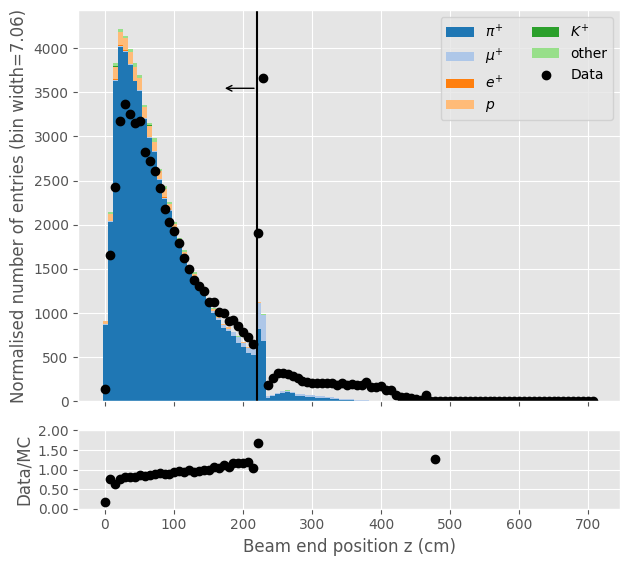

In [11]:
Plots.PlotTagged(samples["mc"].recoParticles.beam_endPos.z, Tags.GenerateTrueBeamParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.beam_endPos.z, x_label = "Beam end position z (cm)", norm = True)
Plots.DrawCutPosition(220, face = "left", arrow_length = 50)


masks = {s : BeamParticleSelection.APA3Cut(samples[s]) for s in samples}
FilterSamples(samples, masks)
# events.Filter([mask], [mask])

number of entries before|after MedianDEdXCut: 80041|76017
number of entries before|after MedianDEdXCut: 55153|51969


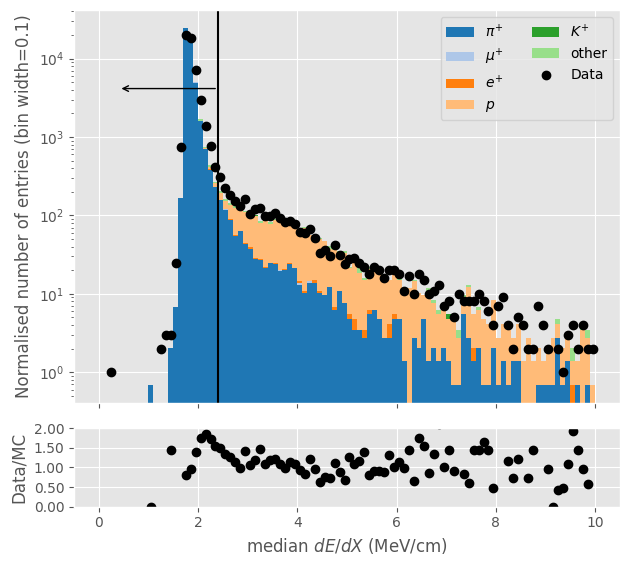

In [12]:
median = {s : PFOSelection.Median(samples[s].recoParticles.beam_dEdX) for s in samples}

Plots.PlotTagged(median["mc"], Tags.GenerateTrueBeamParticleTags(samples["mc"]), data2 = median["data"], y_scale = "log", x_range = [0, 10], x_label = "median $dE/dX$ (MeV/cm)", norm = True)
Plots.DrawCutPosition(2.4, face = "left", arrow_length = 2)

masks = {s : BeamParticleSelection.MedianDEdXCut(samples[s]) for s in samples}
FilterSamples(samples, masks)
# events.Filter([mask], [mask])

In [3]:
fit_files = {
    "mc" : "work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03_fit_values.json",
    "data" : "work/2023/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01/PDSPProd4_data_2GeV_reco2_ntuple_v09_42_03_01_fit_values.json"
}

fit_values = {}
for s in fit_files:
    with open(fit_files[s]) as f:
        fit_values[s] = json.load(f)

masks = {}
masks["mc"] = BeamParticleSelection.CreateDefaultSelection(samples["mc"], False, fit_values["mc"], verbose = False, return_table = False)
masks["data"] = BeamParticleSelection.CreateDefaultSelection(samples["data"], True, fit_values["data"], verbose = False, return_table = False)
FilterSamples(samples, masks)

masks = {s : PFOSelection.GoodShowerSelection(samples[s]) for s in samples}
FilterSamples(samples, masks, True)


number of entries before|after PiBeamSelection: 141548|102443
number of entries before|after PandoraTagCut: 141548|123438
number of entries before|after CaloSizeCut: 141548|125589


/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


number of entries before|after MichelScoreCut: 141548|115682
number of entries before|after BeamQualityCut: 141548|83328
number of entries before|after APA3Cut: 141548|121291
number of entries before|after MedianDEdXCut: 141548|131247
number of entries before|after PiBeamSelection: 1349399|285238
number of entries before|after PandoraTagCut: 1349399|508203
number of entries before|after CaloSizeCut: 1349399|587932
number of entries before|after MichelScoreCut: 1349399|496543
number of entries before|after BeamQualityCut: 1349399|282793
number of entries before|after APA3Cut: 1349399|1265132
number of entries before|after MedianDEdXCut: 1349399|1295793


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


number of entries before|after ValidRecoPositionCut: 174945|167606
number of entries before|after ValidRecoMomentumCut: 174945|155758
number of entries before|after ValidRecoEnergyCut: 174945|155758
number of entries before|after ValidRecoPositionCut: 462634|440746
number of entries before|after ValidRecoMomentumCut: 462634|408436
number of entries before|after ValidRecoEnergyCut: 462634|408436


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_caloWire.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_nHits.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_michelScore.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_startPos.
  warnings.warn(f"Couldn't apply filters

# $\pi^{+}$ Particle Selection

number of entries before|after BeamDaughterCut: 45657|0
number of entries before|after BeamDaughterCut: 133586|0


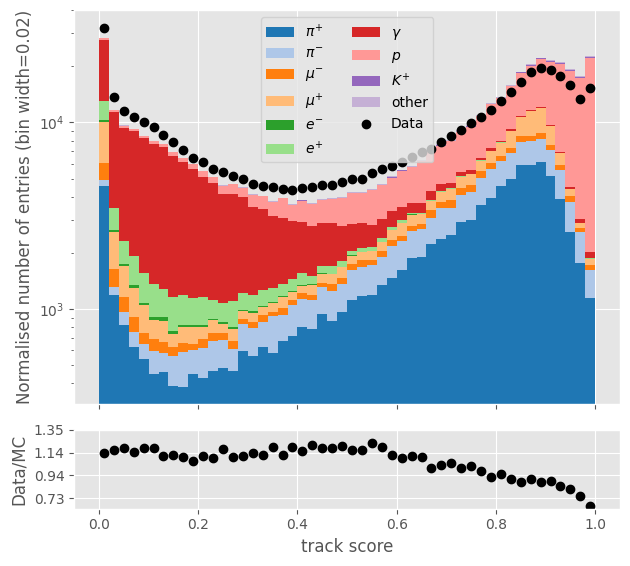

In [11]:
masks = {s : PFOSelection.BeamDaughterCut(samples[s]) for s in samples}
Plots.PlotTagged(samples["mc"].recoParticles.trackScore, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.trackScore, y_scale = "log", x_label = "track score", norm = True)
# events.Filter([mask])


number of entries before|after TrackScoreCut: 153795|98962
number of entries before|after TrackScoreCut: 465545|275172


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_caloWire.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_nHits.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_michelScore.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb1616

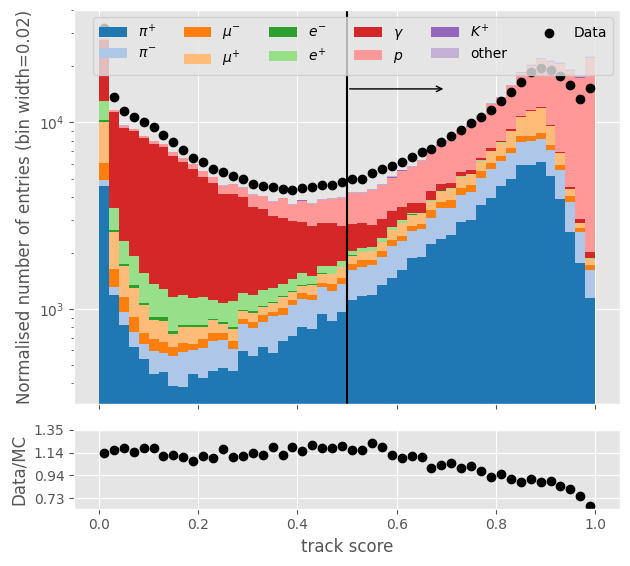

In [15]:
Plots.PlotTagged(samples["mc"].recoParticles.trackScore, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.trackScore, y_scale = "log", bins = 50, ncols = 6, x_label = "track score", norm = True)
Plots.DrawCutPosition(0.5, face = "right")

masks = {s : PFOSelection.TrackScoreCut(samples[s]) for s in samples}
FilterSamples(samples, masks, True)
# mask = PFOSelection.TrackScoreCut(events)
# events.Filter([mask])

number of entries before|after NHitsCut: 98962|93357
number of entries before|after NHitsCut: 275172|258802


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_caloWire.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_nHits.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_michelScore.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb1616

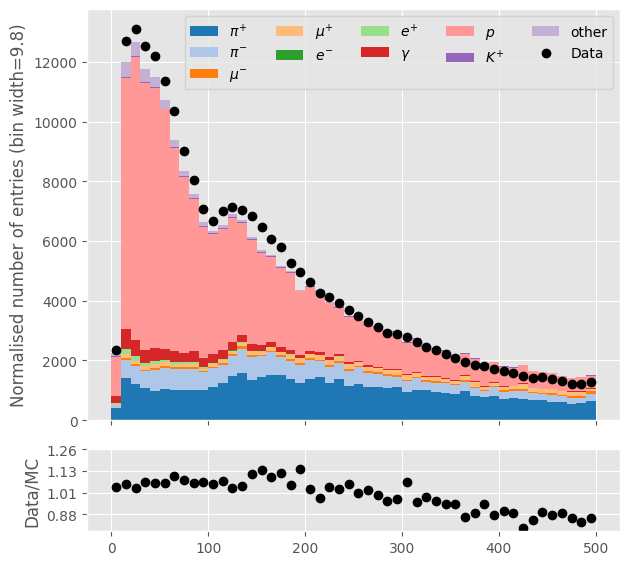

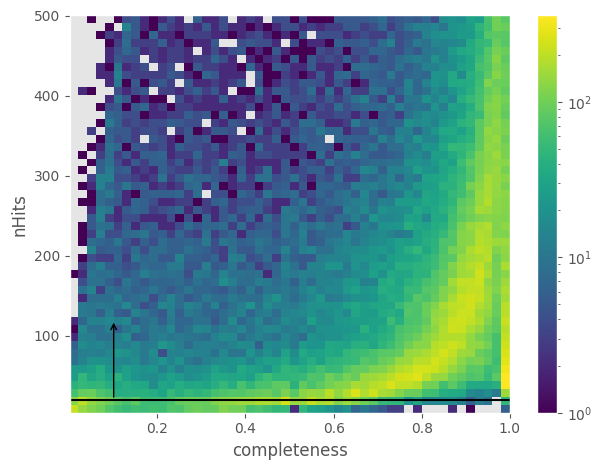

In [19]:
Plots.PlotTagged(samples["mc"].recoParticles.nHits, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.nHits, bins = 50, ncols = 5, x_range = [0, 500], norm = True)
Plots.PlotHist2D(ak.ravel(samples["mc"].trueParticlesBT.completeness), ak.ravel(samples["mc"].recoParticles.nHits), xlabel = "completeness", ylabel = "nHits", y_range = [0, 500], bins = 50)
Plots.DrawCutPosition(20, flip = True, arrow_length = 100, arrow_loc = 0.1)

masks = {s : PFOSelection.NHitsCut(samples[s], 20) for s in samples}
FilterSamples(samples, masks, True)
# mask = PFOSelection.NHitsCut(events, 20)
# events.Filter([mask])

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1049: RuntimeWarning: invalid value encountered in divide
  ratio = h_data / h_mc # data / MC


number of entries before|after PiPlusSelection: 93357|44970
number of entries before|after PiPlusSelection: 258802|119277


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_pandora_tag.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_nHits.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_michelScore.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to _RecoParticleData__beam_startPos.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb1616

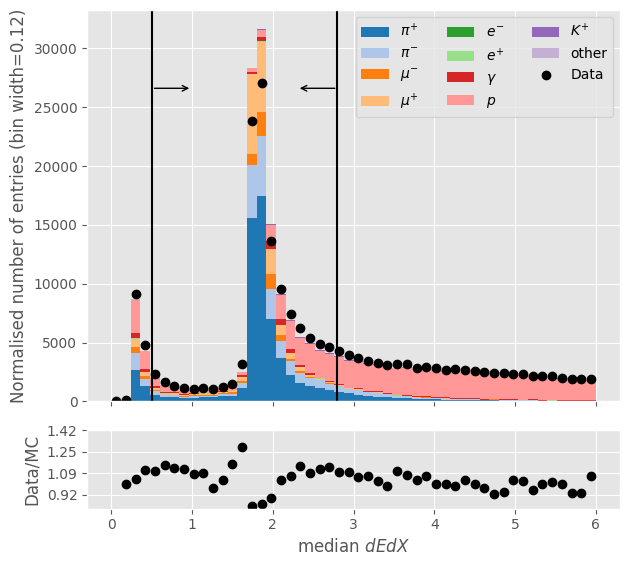

In [22]:
median_dEdX = {s : PFOSelection.Median(samples[s].recoParticles.track_dEdX) for s in samples}
Plots.PlotTagged(median_dEdX["mc"], Tags.GenerateTrueParticleTags(samples["mc"]), data2 = median_dEdX["data"], ncols = 3, x_range = [0, 6], x_label = "median $dEdX$", bins = 50, norm = True)

Plots.DrawCutPosition(0.5, arrow_length = 0.5, face = "right")
Plots.DrawCutPosition(2.8, arrow_length = 0.5, face = "left")

masks = {s : PFOSelection.PiPlusSelection(samples[s]) for s in samples}
FilterSamples(samples, masks, True)

# mask = PFOSelection.PiPlusSelection(events)
# events.Filter([mask], [mask])


(['$K^{+}$',
  '$\\gamma$',
  '$\\mu^{+}$',
  '$\\mu^{-}$',
  '$\\pi^{+}$',
  '$\\pi^{-}$',
  '$e^{+}$',
  '$e^{-}$',
  '$p$',
  'other'],
 [299, 1267, 6549, 2162, 20124, 7086, 158, 7, 7249, 69])

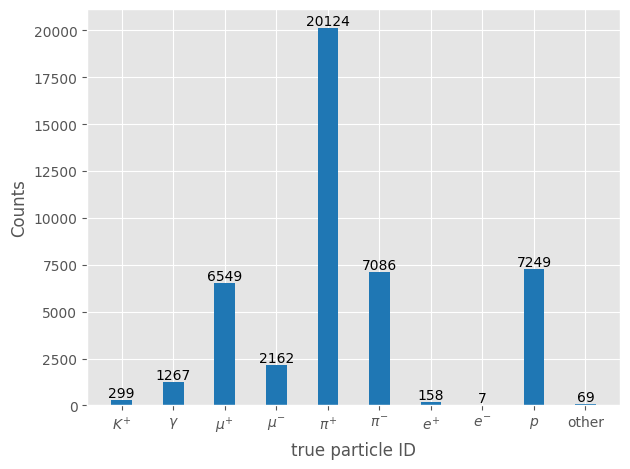

In [24]:
tags = Tags.GenerateTrueParticleTags(samples["mc"])
bar_data = []
for tag in tags:
    bar_data.extend([tag]*ak.sum(tags[tag].mask))

Plots.PlotBar(bar_data, xlabel = "true particle ID")
# print(bar_data)

# print(np.unique(bar_data, return_counts = True))


# photon candidate selection

number of entries before|after EMScoreCut: 155758|55575
number of entries before|after EMScoreCut: 408436|166287


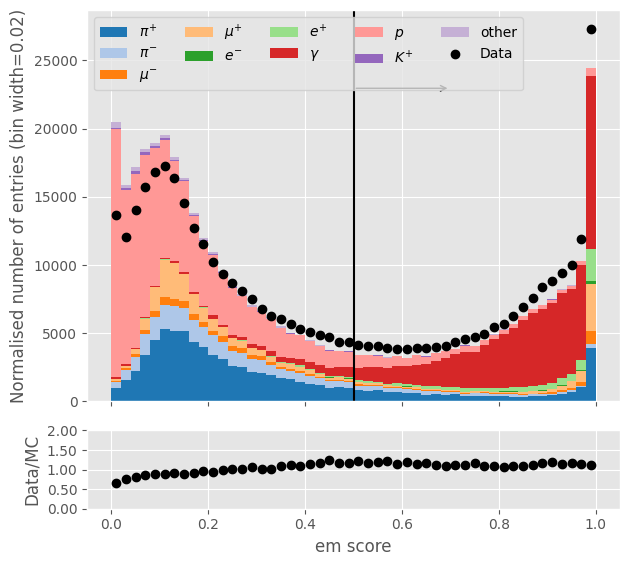

In [5]:
Plots.PlotTagged(samples["mc"].recoParticles.emScore, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.emScore, bins = 50, x_range = [0, 1], ncols = 5, x_label = "em score", norm = True)
Plots.DrawCutPosition(0.5)

masks = {s : PFOSelection.EMScoreCut(samples[s], 0.5) for s in samples}
FilterSamples(samples, masks, True)
# mask = PFOSelection.EMScoreCut(events, 0.5)
# events.Filter([mask])

number of entries before|after NHitsCut: 55575|29161
number of entries before|after NHitsCut: 166287|90118


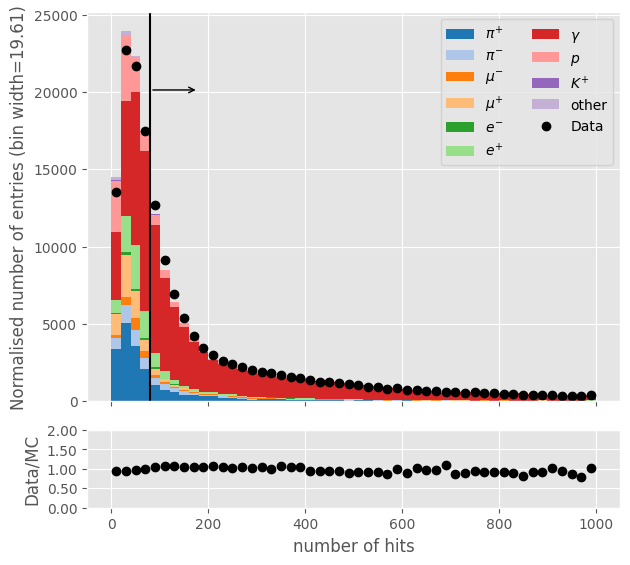

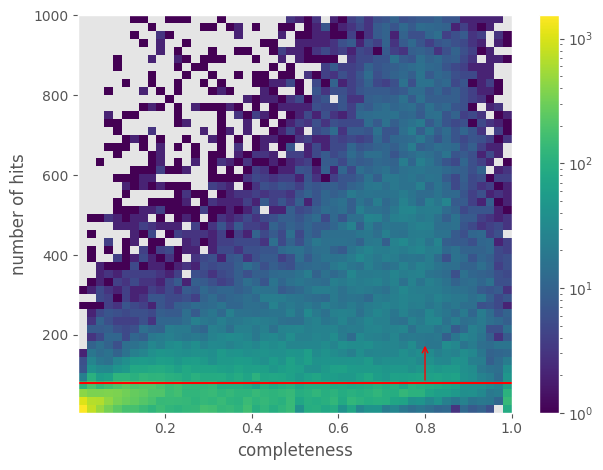

In [6]:
Plots.PlotTagged(samples["mc"].recoParticles.nHits, Tags.GenerateTrueParticleTags(samples["mc"]), data2 = samples["data"].recoParticles.nHits, bins = 50, x_label = "number of hits", x_range = [0, 1000], norm = True)
Plots.DrawCutPosition(80, arrow_length = 100)

Plots.PlotHist2D(ak.ravel(samples["mc"].trueParticlesBT.completeness), ak.ravel(samples["mc"].recoParticles.nHits), bins = 50, x_range = [0, 1],y_range = [0, 1000], xlabel = "completeness", ylabel = "number of hits")
Plots.DrawCutPosition(80, flip = True, arrow_length = 100, color = "red")

masks = {s : PFOSelection.NHitsCut(samples[s], 80) for s in samples}
FilterSamples(samples, masks, True)
# mask = PFOSelection.NHitsCut(events, 80)
# events.Filter([mask])

number of entries before|after BeamParticleDistanceCut: 29161|25642
number of entries before|after BeamParticleDistanceCut: 90118|80621


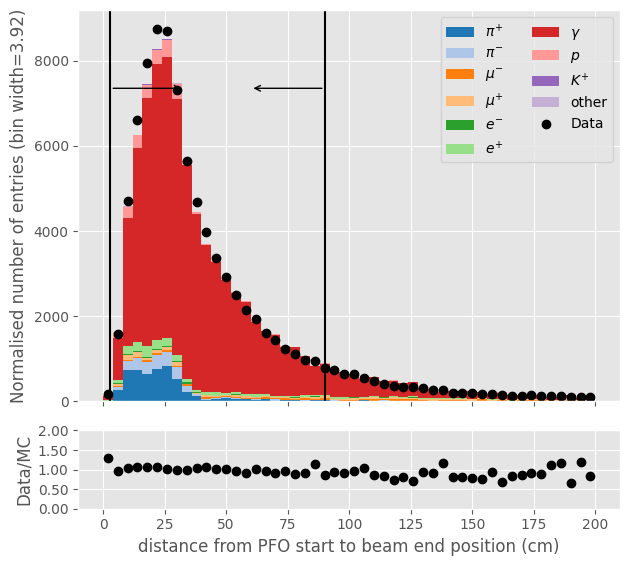

In [7]:
dist = {s : PFOSelection.find_beam_separations(samples[s]) for s in samples}

Plots.PlotTagged(dist["mc"], Tags.GenerateTrueParticleTags(samples["mc"]), data2 = dist["data"], bins = 50, x_range = [0, 200], x_label = "distance from PFO start to beam end position (cm)", norm = True)
Plots.DrawCutPosition(3, arrow_length = 30)
Plots.DrawCutPosition(90, face = "left", arrow_length = 30)

masks = {s : PFOSelection.BeamParticleDistanceCut(samples[s], [3, 90]) for s in samples}
FilterSamples(samples, masks, True)

# mask = PFOSelection.BeamParticleDistanceCut(events, [3, 90])
# events.Filter([mask])

number of entries before|after BeamParticleIPCut: 25642|16574
number of entries before|after BeamParticleIPCut: 80621|51943


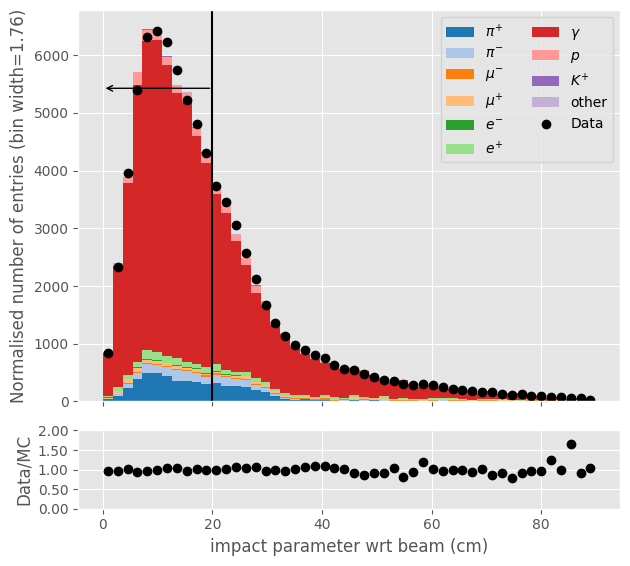

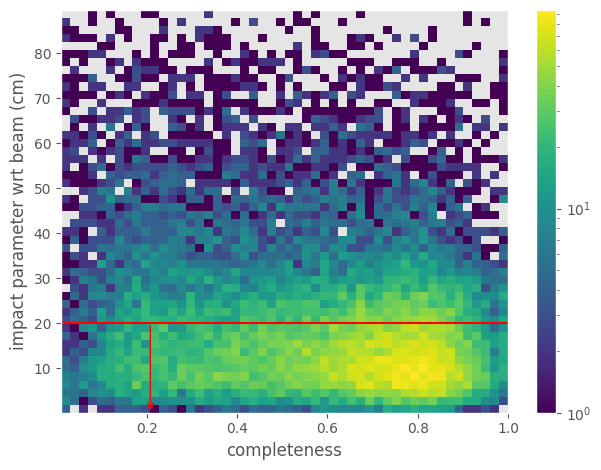

In [8]:
ip = {s : PFOSelection.find_beam_impact_parameters(samples[s]) for s in samples}

Plots.PlotTagged(ip["mc"], Tags.GenerateTrueParticleTags(samples["mc"]), data2 = ip["data"], bins = 50, x_label = "impact parameter wrt beam (cm)", norm = True)
Plots.DrawCutPosition(20, arrow_length = 20, face = "left")

Plots.PlotHist2D(ak.ravel(samples["mc"].trueParticlesBT.completeness), ak.ravel(ip["mc"]), bins = 50, x_range = [0, 1], xlabel = "completeness", ylabel = "impact parameter wrt beam (cm)")
Plots.DrawCutPosition(20, arrow_loc = 0.2, arrow_length = 20, face = "left", flip = True, color ="red")

masks = {s : PFOSelection.BeamParticleIPCut(samples[s], 20) for s in samples}
FilterSamples(samples, masks, True)

# mask = PFOSelection.BeamParticleIPCut(events, 20)
# events.Filter([mask])


(['$K^{+}$',
  '$\\gamma$',
  '$\\mu^{+}$',
  '$\\mu^{-}$',
  '$\\pi^{+}$',
  '$\\pi^{-}$',
  '$e^{+}$',
  '$e^{-}$',
  '$p$',
  'other'],
 [13, 13905, 159, 58, 1140, 411, 331, 53, 495, 9])

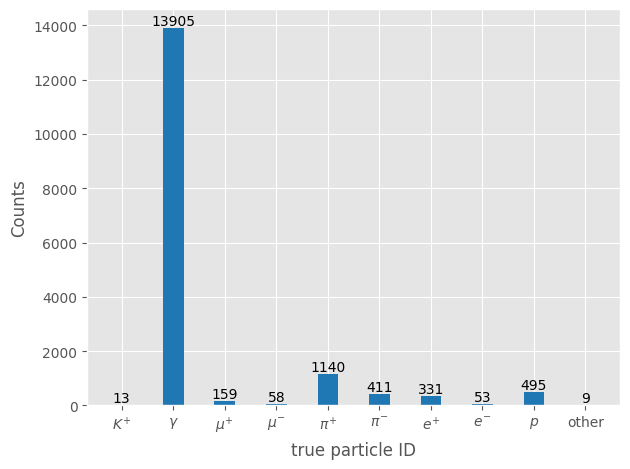

In [9]:
tags = Tags.GenerateTrueParticleTags(samples["mc"])
bar_data = []
for tag in tags:
    bar_data.extend([tag]*ak.sum(tags[tag].mask))

Plots.PlotBar(bar_data, xlabel = "true particle ID")

# $\pi^{0}$ selection

In [4]:
photonCandidates = {s : PFOSelection.InitialPi0PhotonSelection(samples[s]) for s in samples}


number of entries before|after EMScoreCut: 155758|55575
number of entries before|after NHitsCut: 155758|100409
number of entries before|after BeamParticleDistanceCut: 155758|138880
number of entries before|after BeamParticleIPCut: 155758|104613
number of entries before|after VetoBeamParticle: 155758|155758
number of entries before|after EMScoreCut: 408436|166287
number of entries before|after NHitsCut: 408436|257758
number of entries before|after BeamParticleDistanceCut: 408436|370077
number of entries before|after BeamParticleIPCut: 408436|277069
number of entries before|after VetoBeamParticle: 408436|408436


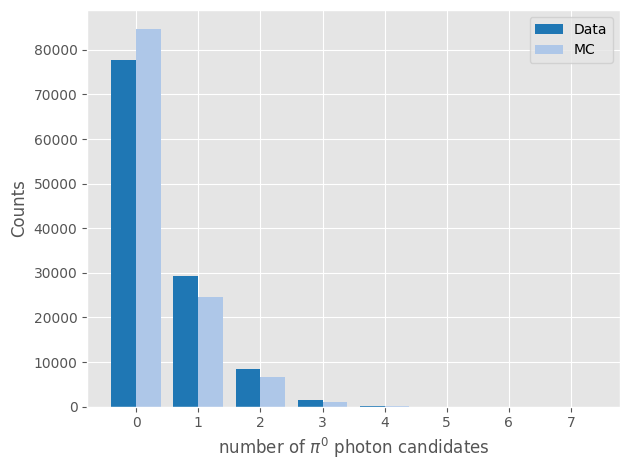

In [5]:
# n_photons = {s : ak.num(samples[s].recoParticles.number) for s in samples}

n_photons = {s : ak.sum(photonCandidates[s], -1) for s in samples}

scale = ak.count(n_photons["data"]) / ak.count(n_photons["mc"])

n_photons_scaled = []
u, c = np.unique(n_photons["mc"], return_counts = True)
for i, j in zip(u, c):
    n_photons_scaled.extend([i]* int(scale * j))

Plots.PlotBarComparision(n_photons_scaled, n_photons["data"], xlabel = "number of $\pi^{0}$ photon candidates", label_1 = "MC", label_2 = "Data")

masks = {s : n_photons[s] == 2 for s in samples}
FilterSamples(samples, masks)
photonCandidates = {s : photonCandidates[s][masks[s]] for s in samples}

# mask = n_photons == 2
# events.Filter([mask], [mask])

no truth information found, sorting showers by reco energy instead

some tags do not have colours, will override them for the default ones


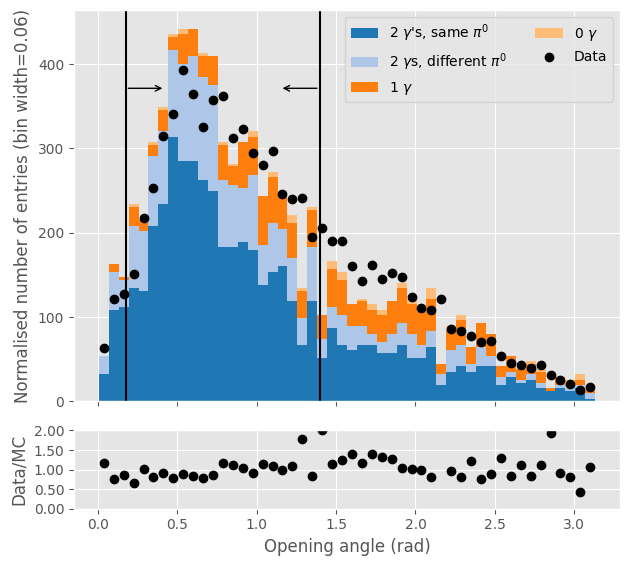

In [6]:
shower_pairs = {s : Master.ShowerPairs(samples[s], shower_pair_mask = photonCandidates[s]) for s in samples}

angle = {s : ak.flatten(shower_pairs[s].reco_angle) for s in samples}

Plots.PlotTagged(angle["mc"], Tags.GeneratePi0Tags(samples["mc"], photonCandidates["mc"]), data2 = angle["data"], bins = 50, x_label = "Opening angle (rad)", norm = True)
Plots.DrawCutPosition(10 * np.pi / 180, face = "right", arrow_length = 0.25)
Plots.DrawCutPosition(80 * np.pi / 180, face = "left", arrow_length = 0.25)

masks = {s : (angle[s] > (10 * np.pi / 180)) & (angle[s] < (80 * np.pi / 180)) for s in samples}
FilterSamples(samples, masks)
photonCandidates = {s : photonCandidates[s][masks[s]] for s in samples}

no truth information found, sorting showers by reco energy instead

some tags do not have colours, will override them for the default ones


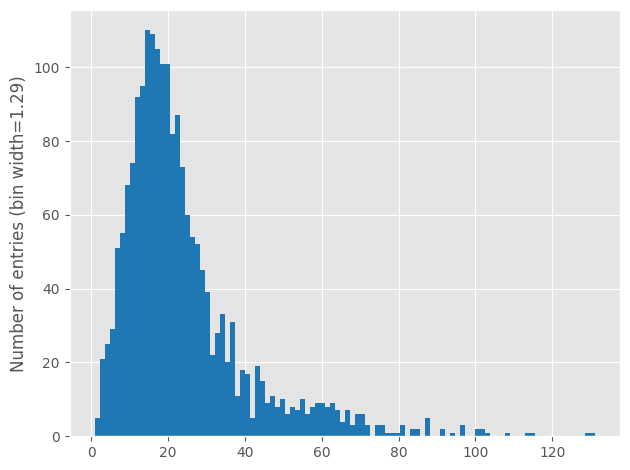

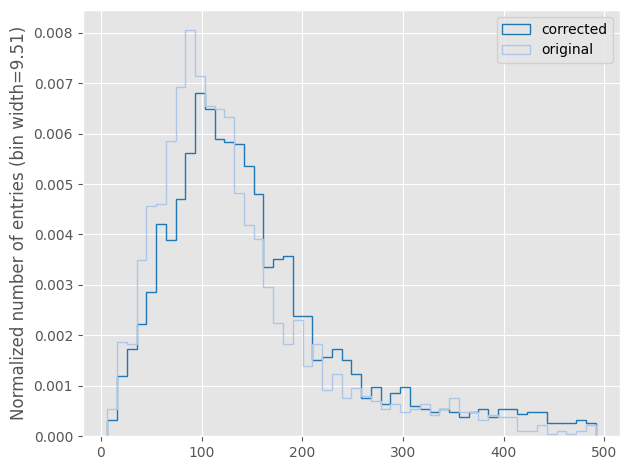

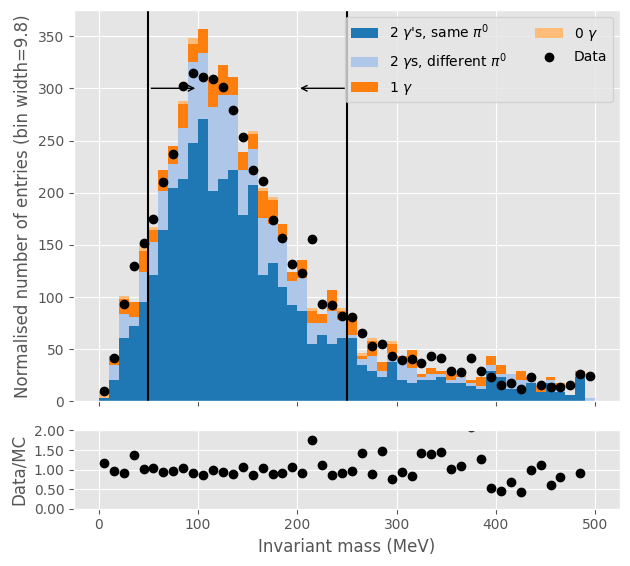

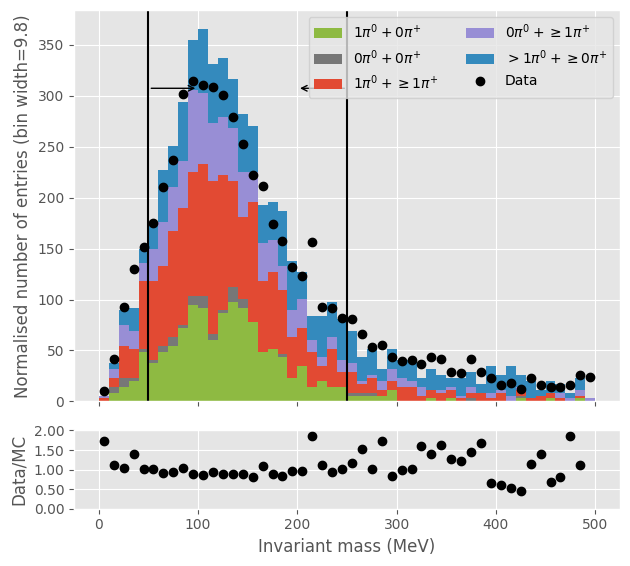

In [18]:
shower_pairs = {s : Master.ShowerPairs(samples[s], shower_pair_mask = photonCandidates[s]) for s in samples}

mass = {s : ak.flatten(shower_pairs[s].reco_mass) for s in samples}

f = 0.8528701062421319

Plots.PlotHist((mass["mc"] / f) - mass["mc"])
Plots.PlotHistComparison([mass["mc"] / f, mass["mc"]], labels = ["corrected", "original"], xRange = [0, 500], bins = 50)

Plots.PlotTagged(mass["mc"] / f, Tags.GeneratePi0Tags(samples["mc"], photonCandidates["mc"]), data2 = mass["data"] / f, bins = 50, x_label = "Invariant mass (MeV)", x_range = [0, 500], norm = True)
Plots.DrawCutPosition(50, face = "right", arrow_length = 50)
Plots.DrawCutPosition(250, face = "left", arrow_length = 50)

Plots.PlotTagged(mass["mc"] / f, Tags.GenerateTrueFinalStateTags(samples["mc"]), data2 = mass["data"] / f, bins = 50, x_label = "Invariant mass (MeV)", x_range = [0, 500], norm = True)
Plots.DrawCutPosition(50, face = "right", arrow_length = 50)
Plots.DrawCutPosition(250, face = "left", arrow_length = 50)

# mask = (mass > 50) & (mass < 250)
# events.Filter([mask], [mask])

In [26]:
event_topology_tags = Tags.GenerateTrueFinalStateTags(samples["mc"])

for t in event_topology_tags:
    print(event_topology_tags[t].name_simple, ak.sum(event_topology_tags[t].mask), ak.count(event_topology_tags[t].mask))

exclusive signal 237 1921

background 350 1921

sideband 312 1921

sideband 904 1921

sideband 118 1921